# Project: Predicting Housing Prices in King County

We will use the **King County House Sales dataset**:  
[House Sales Prediction (Kaggle)](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)

# Additional Work

- **Implement k-nearest imputation to allow the model to learn from earlier sales data.**
    - total_months: running number of months starting with May 2014 = 0.
    - loop through data in one-month increments. allow imputer to see all previous sales history data, imput prediction from sales history.
    - results from each run is joined back to dataset then collapsed into a single column, price_knn
    - review imputed data for each month using MAE. MAE is ~215k for the first month (month 1, no data for month 0). Big model gains across months 1-3, smaller gains for months 3-6, and relatively stable over months 6-12.
    - Decided to drop data for months 0-4, roughly 1/2 of dataset. The smaller dataset leaves R-squared unchanged but MAE increases by 3%
    - When price_knn column is added to the model, MAE improved 19% over baseline, including the impact of the smaller dataset.
- **Improved zip code pre-process**
    - Previously ignored zipcode. Instead, rank zipcodes by median sale price, and use this for ordinalization.. The resulting distribution is monotonic.
    - To completely eliminate the risk of leakage (the actual sale price of the home included, despite agg, then rank), I have limited the rank dataset to months 0-4, since I had already decided to throw this data out anyway.
    - Adding zipcode was an additional 10% over baseline MAE on top of KNN imputation
- **Utilize neighborhood definitions to improve on zipcode clustering.**
    - Downloaded [King County Metro Neighborhoods](https://gis-kingcounty.opendata.arcgis.com/datasets/9764aad9b2d74853a00d949f987e8a67/explore) shapefile, opened and joined using geopandas
    - Utilized the same ordinalization approach from zip code to neighborhood
    - Adding zipcode was an additional 3% over baseline MAE on top of zipcode + KNN, but RMSE improved by 11 points, indicating that the smaller spatial grouping is improving fit for high flier data. Testing Neighborhood without Zipcode confirms that Neighborhood that it is a better improvement to RMSE than MAE compared to zipcode.
- I was using the minimal 10-sigma filtering up until this point. Increasing filtering to 6-sigma brings the linear fit up to -35% MAE and -33% RMSE over baseline model, with 0.79 R-squared. And remember, *these improvements are after dropping half of the dataset to train the knn model before feeding into regression.*
- Using best Ridge and Lasso models add a few additional points for MAE. Interestingly, Lasso has elminated the new neighborhood column.
- Despite all this, the MAE is still +/- 20% on a 438k median home. So more work is needed.

| Test | R2 | MAE | RMSE |
| ----------- | ----------- | ----------- | ----------- |
| Model Baseline (linear, 10-sigma filter) | 0.60 | 140413 | 200914 |
| Baseline, remove months 0-4 | 0.61 | +3% | +13% |
| Add KNN, 12 months data| 0.66 | -8% | -7% |
| Add KNN, remove months 0-4 | 0.73 | -18% | -6% |
| Zipcode + KNN | 0.77 | -28% | -11% |
| Neighborhood + Zipcode + KNN | 0.76 | -31% | -22% |
| Neighborhood + KNN | 0.72 | -21% | -16% |
| Neighborhood + Zipcode + KNN + 6-sigma filtering | 0.79 | -35% | -33% |
| Best model + Ridge, alpha=1000 | 0.79 | -36% | -33% |
| Best model + Lasso, alpha=10000 | 0.79 | -37% | -33% |

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import geopandas as gpd

In [249]:
df = pd.read_csv('kc_house_data.csv')

# Open shapefile in geopandas
shape = gpd.read_file('./King_County_Neighborhood_Areas.shp')
shape['area'] = shape.area
shape = shape.to_crs('EPSG:4326')

# Move DF to GDF and perform left join
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.long, df.lat), crs="EPSG:4326")
df1 = pd.DataFrame(gpd.sjoin(gdf, shape, how='left', predicate='within'))

# Some neighborhoods are overlapping: Ballard and South Ballard. Keep the entry with the smaller area.
# I incorporated the id duplication removal here (sort by date, remove oldest)
df1 = df1.sort_values(['id', 'date', 'area'], ascending=[True,False,True])
df1 = df1.drop_duplicates(subset=["id"])

# Column cleanup. Merge back to df.
df1 = df1.rename(columns={'NEIGHBORHO':'neighborhood'})
df = df1.drop(columns=['geometry', 'NEIGH_NUM', 'index_right', 'area'])

In [250]:
# date column cleanup.

df['year'] = df['date'].str[:4].astype('int')
df['month'] = df['date'].str[4:6].astype('int')
df['total_months'] = df['date'].map(lambda x: (int(x[:4]) - 2014) * 12 + int(x[4:6]) - 5) #Running number of months starting May 2015
df['date'] = pd.to_datetime(df['date'])

In [251]:
# replace zipcode with ranked list
zipcode_rank = df['price'][df['total_months']<5].groupby(df['zipcode']).median().sort_values().reset_index().reset_index().values.tolist()
for zipcode in zipcode_rank:
    df = df.replace( to_replace=zipcode[1], value=zipcode[0])
df['zipcode'] = df['zipcode'].fillna(df['zipcode'].median())

# use similar method to ordinalize neighborhood.
neighborhood_rank = df['price'][df['total_months']<5].groupby(df['neighborhood']).median().sort_values().reset_index().reset_index().values.tolist()
for hood in neighborhood_rank:
    df['neighborhood_rank'] = df['neighborhood'].map(lambda x: hood[0] if x == hood[1] else np.nan)
df['neighborhood_rank'] = df['neighborhood_rank'].fillna(df['neighborhood_rank'].median())
df['neighborhood_rank'] = df['neighborhood_rank'].astype('int')
df = df.drop(columns='neighborhood')


In [252]:
# create age columns

df['yr_built_or_reno'] = np.select([(df['yr_renovated'] > 0), (df['yr_renovated'] == 0)],
                                          [df['yr_renovated'], df['yr_built']])

df['age_built_or_reno'] = df['year'] - df['yr_built_or_reno']

In [253]:
# drop duplicates (keep newest)
# removed/redundant

# manual data filtering
df = df.drop(df[df['bedrooms'] == 33].index)

df = df.sort_values(['date'], ascending=[True])

#drop date column - no longer needed
df = df.drop(columns=['date'])

In [254]:
# implement winsorized columns

df['bedrooms_win'] = df['bedrooms'].where(df['bedrooms'] < 8, other=8)
df['bathrooms_win'] = np.floor(df['bathrooms'].where(df['bathrooms'] < 6, other=6)).astype('int')
df['multi_story'] = (np.floor(df['floors'].where(df['floors'] < 2, other=2)) - 1).astype('int')

In [255]:
#use knn imputer to create price_knn column from historical data.
    
#features for knn imputer model.
impute_cols = ['id', 'total_months', 'lat', 'long', 'sqft_living', 'grade', 'bedrooms_win',
               'bathrooms_win', 'price_i']

df_knn = df.copy()

for month_i in df_knn['total_months'].unique():
    #skip first month - no historical data
    if month_i == 0:
        continue

    df_impute = df_knn[df_knn['total_months'] <= month_i]                            # create data subset up to current month
    df_impute['price_i'] = df_impute['price'].copy()                         # copy price data to price_i
    df_impute['price_i'] = df_impute['price_i'].\
         where(df_impute['total_months'] < month_i, other=None)              # set price_i to missing for current month

    #KNN imputer
    imputer = KNNImputer(n_neighbors=5, weights='distance')                  
    impute_results = imputer.fit_transform(df_impute[impute_cols])    

    #left join on id to add imputed data column back to df_knn
    df_imputed = pd.DataFrame(impute_results, columns=impute_cols)           
    df_imputed = df_imputed[['id', 'price_i']][df_imputed['total_months'] == month_i]
    df_imputed.columns = ['id', 'price_'+str(month_i)]

    df_knn = df_knn.merge(df_imputed, on='id', how='left')


/var/folders/8b/gg85hlbn2qn8k75vsncmztbc0000gp/T/ipykernel_64277/4203717763.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impute['price_i'] = df_impute['price'].copy()                         # copy price data to price_i
/var/folders/8b/gg85hlbn2qn8k75vsncmztbc0000gp/T/ipykernel_64277/4203717763.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impute['price_i'] = df_impute['price_i'].\
/var/folders/8b/gg85hlbn2qn8k75vsncmztbc0000gp/T/ipykernel_64277/4203717763.py:15: SettingWithCopyWarning:

In [256]:
#display MAE for each month

price_i_cols = list(df_knn.filter(regex='price_').columns.sort_values())

print('MAE for KNN Imputer by month')

for month in price_i_cols:
    mae = mean_absolute_error(df_knn['price'][df_knn['total_months'] == int(month.replace('price_', ''))],
                              df_knn[month][df_knn['total_months'] == int(month.replace('price_', ''))])
    print(month, '   ', round(mae,2))

#collapse all price cols to single column, then drop
df_knn['price_knn'] = df_knn[price_i_cols].sum(axis=1)
df_knn = df_knn.drop(columns=price_i_cols)

#Drop first x months of data based on knn imputer MAE.

df_knn = df_knn.drop(df_knn[df_knn['total_months']<5].index)

MAE for KNN Imputer by month
price_1     214916.96
price_10     131420.22
price_11     127381.03
price_12     134180.26
price_2     180522.64
price_3     166850.51
price_4     151933.36
price_5     148467.55
price_6     141245.28
price_7     131042.46
price_8     144402.89
price_9     124513.9


In [257]:
# Uncomment to initialize results table. Comment out to protect work history.

#results_list = []

In [268]:
sd_filter = 6

# Apply sigma filtering
stats_df = df_knn.describe().round(2).reset_index()
df_filtered = df_knn.copy()
for param in df_filtered.columns.to_list():
    sd_filter_thresh = stats_df.loc[1, param] + sd_filter * stats_df.loc[2, param]
    df_filtered = df_filtered.drop(df_filtered[df_filtered[param] > sd_filter_thresh].index)

# User selected columns  -- Default if all three code blocks are run.
col_list = ['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade',
            'sqft_above', 'sqft_basement', 'sqft_living15','sqft_lot15', 'age_built_or_reno',
            'bedrooms_win', 'bathrooms_win', 'multi_story', 'price_knn', 'zipcode', 'neighborhood_rank']
#col_list = ['price_knn', 'sqft_living', 'grade']
x_input = df_filtered[col_list]
y_input = df_filtered['price']

# train test split
x_train, x_test, y_train, y_test = train_test_split(x_input,
                                                    y_input,
                                                    test_size=0.10,
                                                    random_state=42)

# Z-scaling
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)
x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)

test_notes = input('Record test notes:')

# Linear Regression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)

results_list.append(['linear',
                     test_notes,
                     x_train.columns,
                     len(x_train.columns),
                     sd_filter,
                     df_filtered.shape[0],
                     round(r2_score(y_train, y_pred_train),2),
                     round(r2_score(y_test, y_pred_test),2),
                     round(mean_absolute_error(y_train, y_pred_train),2),
                     round(mean_absolute_error(y_test, y_pred_test),2),
                     round(root_mean_squared_error(y_train, y_pred_train),2),
                     round(root_mean_squared_error(y_test, y_pred_test),2),
                     y_test.median(),
                     np.sum(lr.coef_ != 0),
                     lr.coef_,
                     lr.intercept_
                    ])

# Ridge Regression
for i in [0.1,1,10,100,1000,10000]:
    lr = Lasso(alpha=i)
    lr.fit(x_train, y_train)
    y_pred_train = lr.predict(x_train)
    y_pred_test = lr.predict(x_test)
    
    results_list.append(['lasso - ' + str(i),
                         test_notes,
                         x_train.columns,
                         len(x_train.columns),
                         sd_filter,
                         df_filtered.shape[0],
                         round(r2_score(y_train, y_pred_train),2),
                         round(r2_score(y_test, y_pred_test),2),
                         round(mean_absolute_error(y_train, y_pred_train),2),
                         round(mean_absolute_error(y_test, y_pred_test),2),
                         round(root_mean_squared_error(y_train, y_pred_train),2),
                         round(root_mean_squared_error(y_test, y_pred_test),2),
                         y_test.median(),
                         np.sum(lr.coef_ != 0),
                         lr.coef_,
                         lr.intercept_
                        ])

# Print results as DataFrame
result_df = pd.DataFrame(results_list, columns=['model', 'test notes', 'columns', 'num_columns', 'Sigma Filter', 'num_rows',
                                                'r2_train', 'r2_test', 'mae_train', 'mae_test', 'rmse_train', 'rmse_test',
                                                'median price', 'n_features', 'coefficients', 'intercept'])

result_df.tail(6)

Record test notes: Hypertuning on lasso


/Volumes/Dionysus/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.009e+12, tolerance: 9.723e+10
  model = cd_fast.enet_coordinate_descent(
/Volumes/Dionysus/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.014e+12, tolerance: 9.723e+10
  model = cd_fast.enet_coordinate_descent(
/Volumes/Dionysus/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want 

,model,test notes,columns,num_columns,Sigma Filter,num_rows,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,median price,n_features,coefficients,intercept
32,lasso - 0.1,Hypertuning on lasso,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,93681.41,91240.02,143574.01,134213.81,437609.0,15,"[170415.07932442075, 7521.188721698368, 0.0, 3...",520491.657274
33,lasso - 1,Hypertuning on lasso,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,93681.39,91239.85,143574.01,134213.74,437609.0,15,"[168336.14593114957, 7518.38735574994, 0.0, 32...",520491.657274
34,lasso - 10,Hypertuning on lasso,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,93681.18,91238.14,143574.02,134213.07,437609.0,15,"[147546.81199848704, 7490.373696265924, 0.0, 3...",520491.657274
35,lasso - 100,Hypertuning on lasso,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,93642.32,91167.97,143575.11,134170.32,437609.0,14,"[92945.91850405732, 7174.708617332444, 0.0, 32...",520491.657274
36,lasso - 1000,Hypertuning on lasso,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,93358.70,90619.91,143685.18,133873.93,437609.0,14,"[92073.44231112771, 4041.104799251032, 0.0, 31...",520491.657274
37,lasso - 10000,Hypertuning on lasso,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.77,0.79,93139.84,88481.44,147137.06,134128.17,437609.0,8,"[86556.61741695036, -0.0, 0.0, 26009.611559634...",520491.657274


In [287]:
#Show best model from results
best_run = result_df[result_df['mae_test'] == result_df['mae_test'].min()].reset_index()
display(result_df.head(2))
display(best_run)

#Get best fit params
br_cols = best_run.loc[0, 'columns']
br_coeff = best_run.loc[0, 'coefficients']
br_intercept = best_run.loc[0, 'intercept']

#Show coefficients from best fit
coeff_df = pd.DataFrame(list(zip(br_cols, br_coeff)), columns = ['columns', 'coefficients'])
coeff_df['abs_coeff'] = abs(coeff_df['coefficients'])
coeff_df = coeff_df.sort_values('abs_coeff', ascending=False).reset_index()

display(coeff_df[['columns', 'coefficients']])

,model,test notes,columns,num_columns,Sigma Filter,num_rows,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,median price,n_features,coefficients,intercept
0,linear,"Baseline test to reproduce original testing, n...","Index(['sqft_living', 'sqft_lot', 'waterfront'...",14,10,21212,0.63,0.6,136039.03,140413.98,202746.77,200914.36,449975.0,14,"[65112.43947350647, -2902.626349913582, 7.2759...",531535.856469
1,ridge - 1000,"Baseline test to reproduce original testing, n...","Index(['sqft_living', 'sqft_lot', 'waterfront'...",14,10,21212,0.62,0.6,135482.29,139999.30,203106.91,200662.24,449975.0,13,"[63885.31421462761, -2797.8073431487373, 0.0, ...",531535.856469


,index,model,test notes,columns,num_columns,Sigma Filter,num_rows,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,median price,n_features,coefficients,intercept
0,37,lasso - 10000,Hypertuning on lasso,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.77,0.79,93139.84,88481.44,147137.06,134128.17,437609.0,8,"[86556.61741695036, -0.0, 0.0, 26009.611559634...",520491.657274


,columns,coefficients
0,zipcode,89423.220703
1,sqft_living,86556.617417
2,price_knn,77058.048190
3,grade,59706.587138
4,view,26009.611560
5,age_built_or_reno,25729.742558
6,bathrooms_win,14438.984171
7,condition,3072.304013
8,multi_story,-0.000000
9,bedrooms_win,-0.000000


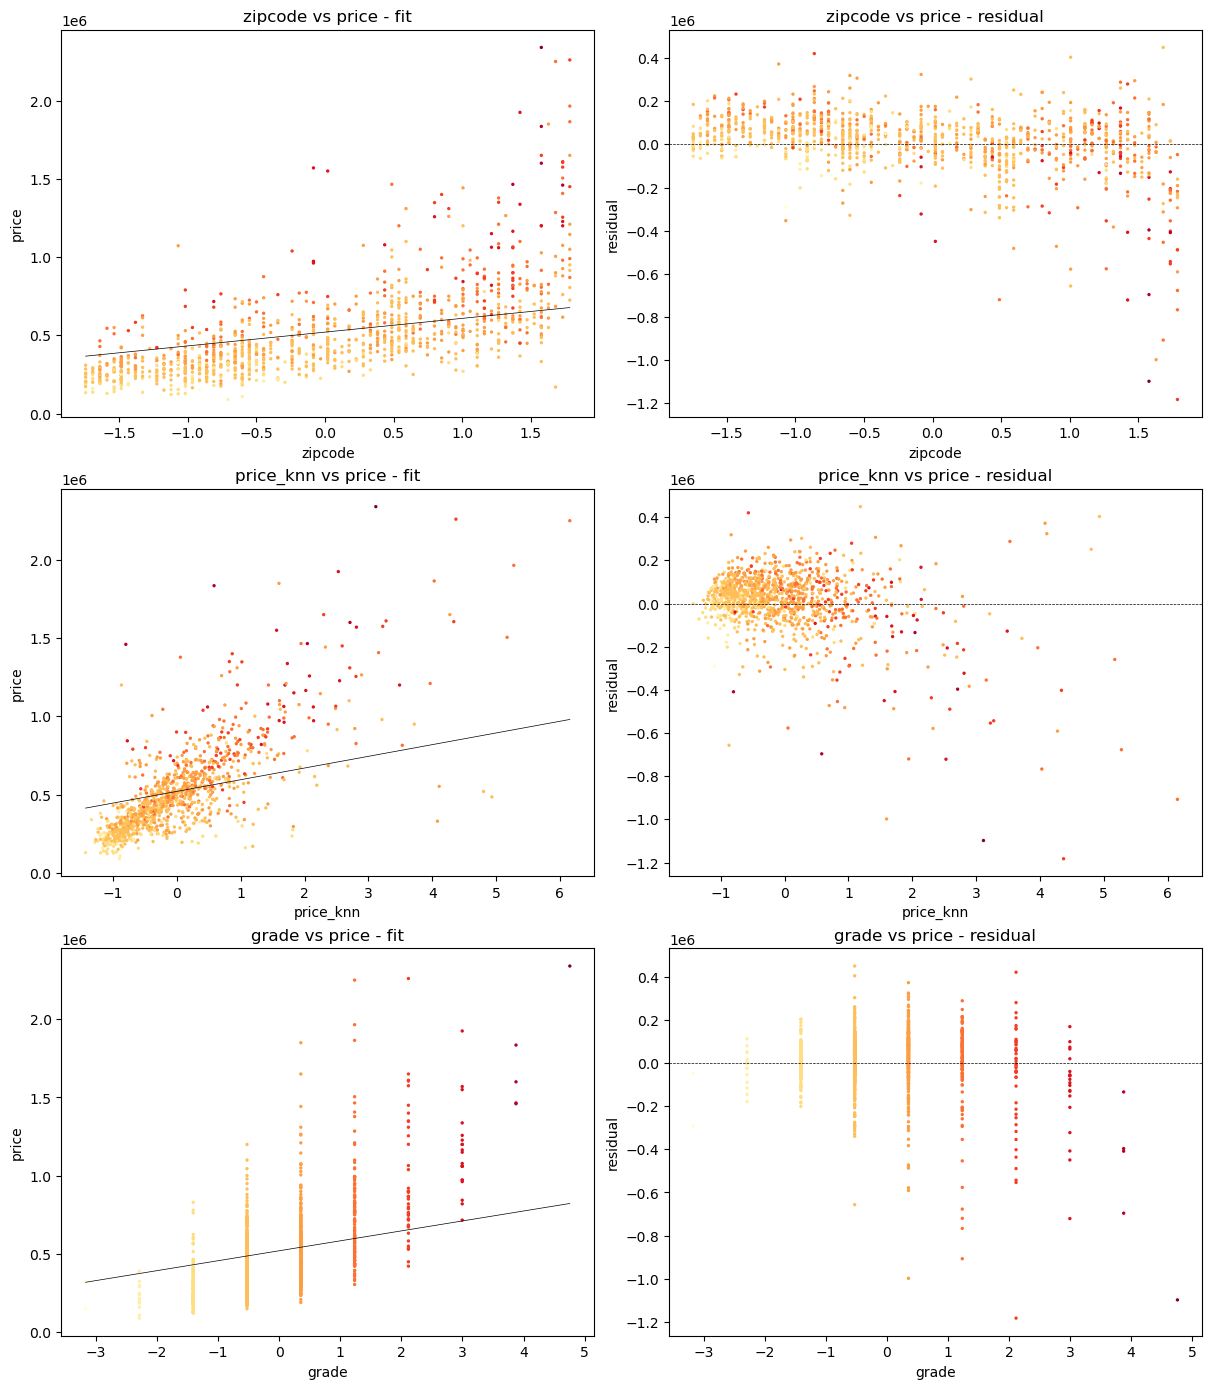

In [266]:
# Plot top 3 features from coefficient table

length = coeff_df.shape[0]

plt.figure(figsize=(12,4*length), layout='constrained')

for i in range(3):
    param_name = coeff_df.loc[i, 'columns']
    param_coeff = coeff_df.loc[i, 'coefficients']
    
    # Plot test-dataset feature vs. price
    plt.subplot(length, 2, i*2+1)
    plt.scatter(x_test[param_name], y_test, s=2, c=x_test['grade'], cmap='YlOrRd')
    plt.xlabel(param_name)
    plt.ylabel('price')
    plt.title(f'{param_name} vs price - fit')
    
    # Plot line of fit
    x_fit = np.array([x_test[param_name].min(),
                      x_test[param_name].max()])
    y_fit = np.array([br_intercept + param_coeff * x_test[param_name].min(),
                     br_intercept + param_coeff * x_test[param_name].max()])
    plt.plot(x_fit, y_fit, color='black', label='Predicted', linewidth=0.5)

    # Plot test-dataset residual vs. price
    y_residuals = y_pred_test - y_test
    
    plt.subplot(length, 2, i*2+2)
    plt.scatter(x_test[param_name], y_residuals, s=2, c=x_test['grade'], cmap='YlOrRd')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.xlabel(param_name)
    plt.ylabel('residual')
    plt.title(f'{param_name} vs price - residual')

plt.show()

In [291]:
result_df[result_df['model'] == 'linear']

,model,test notes,columns,num_columns,Sigma Filter,num_rows,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,median price,n_features,coefficients,intercept
0,linear,"Baseline test to reproduce original testing, n...","Index(['sqft_living', 'sqft_lot', 'waterfront'...",14,10,21212,0.63,0.60,136039.03,140413.98,202746.77,200914.36,449975.0,14,"[65112.43947350647, -2902.626349913582, 7.2759...",531535.856469
2,linear,"Enabled total_months < 5 filter, but no knn","Index(['sqft_living', 'sqft_lot', 'waterfront'...",14,10,11557,0.61,0.61,139218.10,145747.02,205008.56,226679.28,449925.0,14,"[61972.32076416461, -1607.7576245002128, -7.27...",527124.046919
4,linear,price_knn turned on,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",15,10,11557,0.73,0.73,111243.25,114708.39,171414.12,188382.45,449925.0,15,"[56071.36782912525, 4751.882917284704, -1.0913...",527124.046919
6,linear,"knn in model, but drop months filter","Index(['sqft_living', 'sqft_lot', 'waterfront'...",15,10,21212,0.68,0.66,125301.18,128935.85,186862.16,185984.16,449975.0,15,"[63836.580507087514, -492.56240617083677, 7.27...",531535.856469
8,linear,"Full KNN test, limited to 3 features","Index(['price_knn', 'sqft_living', 'grade'], d...",3,10,11557,0.70,0.70,118101.40,120346.06,182031.59,200859.70,449925.0,3,"[157641.74819859018, 97136.27190897797, 71133....",527124.046919
10,linear,Added improved zipcode to model,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",16,10,11557,0.78,0.76,98880.18,103556.33,155839.07,176908.82,449925.0,16,"[65269.3375986993, 5003.536314404089, -1.81898...",527124.046919
12,linear,Added neighborhood,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,10,11565,0.77,0.76,99806.85,98598.06,158303.50,155720.30,445000.0,16,"[66937.2254416404, 6297.361860466321, -2.91038...",528134.110684
14,linear,Testing Neighborhood without Zipcode,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",16,10,11565,0.73,0.72,112254.53,111074.14,173944.33,167640.61,445000.0,15,"[57850.44279179034, 5068.685675434754, -3.6379...",528134.110684
18,linear,Best model with 6 sigma filtering,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,93681.42,91240.04,143574.01,134213.81,437609.0,16,"[57303.260979860235, 7521.499984581475, -1.818...",520491.657274
20,linear,Hypertuning best model,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,93681.42,91240.04,143574.01,134213.81,437609.0,16,"[57303.260979860235, 7521.499984581475, -1.818...",520491.657274


In [294]:
result_df[result_df['model'] == 'ridge - 1000']

,model,test notes,columns,num_columns,Sigma Filter,num_rows,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,median price,n_features,coefficients,intercept
1,ridge - 1000,"Baseline test to reproduce original testing, n...","Index(['sqft_living', 'sqft_lot', 'waterfront'...",14,10,21212,0.62,0.60,135482.29,139999.30,203106.91,200662.24,449975.0,13,"[63885.31421462761, -2797.8073431487373, 0.0, ...",531535.856469
3,ridge - 1000,"Enabled total_months < 5 filter, but no knn","Index(['sqft_living', 'sqft_lot', 'waterfront'...",14,10,11557,0.61,0.61,138721.28,145095.72,206044.62,228488.67,449925.0,13,"[60424.57888844097, -2160.7729866094787, 0.0, ...",527124.046919
5,ridge - 1000,price_knn turned on,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",15,10,11557,0.73,0.73,111243.45,114852.11,172485.85,190045.83,449925.0,14,"[51516.325091292114, 2521.812483214033, 0.0, 2...",527124.046919
7,ridge - 1000,"knn in model, but drop months filter","Index(['sqft_living', 'sqft_lot', 'waterfront'...",15,10,21212,0.68,0.66,124660.82,128520.96,187195.26,185786.44,449975.0,14,"[61195.70274700008, -673.4651000977309, 0.0, 3...",531535.856469
9,ridge - 1000,"Full KNN test, limited to 3 features","Index(['price_knn', 'sqft_living', 'grade'], d...",3,10,11557,0.69,0.69,118291.16,119591.42,182588.83,201507.26,449925.0,3,"[144609.56405768744, 92269.63048826963, 74106....",527124.046919
11,ridge - 1000,Added improved zipcode to model,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",16,10,11557,0.77,0.76,97328.83,101583.98,156759.48,178401.30,449925.0,15,"[56627.7359255498, 3567.045146856237, 0.0, 295...",527124.046919
13,ridge - 1000,Added neighborhood,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,10,11565,0.77,0.76,98196.95,96921.93,159212.65,156478.82,445000.0,15,"[58149.39591496133, 4921.865494779041, 0.0, 30...",528134.110684
15,ridge - 1000,Testing Neighborhood without Zipcode,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",16,10,11565,0.72,0.72,112243.48,110502.99,175000.10,169376.47,445000.0,14,"[53143.51610884024, 3208.4616129999936, 0.0, 2...",528134.110684
19,ridge - 1000,Best model with 6 sigma filtering,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,92461.19,89311.15,144411.08,133680.40,437609.0,15,"[50313.16904671359, 5551.139792169857, 0.0, 30...",520491.657274
25,ridge - 1000,Hypertuning best model,"Index(['sqft_living', 'sqft_lot', 'waterfront'...",17,6,11396,0.78,0.79,92461.19,89311.15,144411.08,133680.40,437609.0,15,"[50313.16904671359, 5551.139792169857, 0.0, 30...",520491.657274
